In [19]:
# mute logging in jupyter notebook
import Logging
Logging.disable_logging(Logging.Warn)

# load dependency
using Distributions, LinearAlgebra, GLM, DataFrames, Printf
using Plots, Plots.PlotMeasures, StatsPlots
import Random

In [2]:
function randirect(ϕ₀::Vector{<:Real};T::Real=1,Dᵣ=1,Δt=0.1)
    Δtξ = Normal(0,√Δt)
    N = length(ϕ₀)
    ts = 0:Δt:T
    M = length(ts)
    ϕ = ϕ₀ .+ [zeros(N) √(2Dᵣ).*cumsum(rand(Δtξ,(N,M-1)),dims=2)]
    return (ts=ts,ϕ=ϕ)
end

randirect (generic function with 1 method)

In [3]:
function aBm(X₀::Vector{<:Real},Y₀::Vector{<:Real},ϕ₀::Vector{<:Real};T::Real=1,Dᵣ=1,v=1,Δt=0.1)
    ts,ϕ = randirect(ϕ₀;T=T,Dᵣ=Dᵣ,Δt=Δt)
    ϕᵢ = ϕ[:,1:end-1]
    X = X₀ .+ [zero(X₀) cumsum(v.*cos.(ϕᵢ).*Δt, dims=2)]
    Y = Y₀ .+ [zero(Y₀) cumsum(v.*sin.(ϕᵢ).*Δt, dims=2)]
    return (ts=ts,X=X,Y=Y,ϕ=ϕ)
end

aBm (generic function with 1 method)

In [36]:
N = 1000
Random.seed!(123456)
ts,X,Y,ϕ = aBm(zeros(N),zeros(N),rand(Uniform(0,2π),N);T=50,Dᵣ=1,v=1,Δt=0.1);

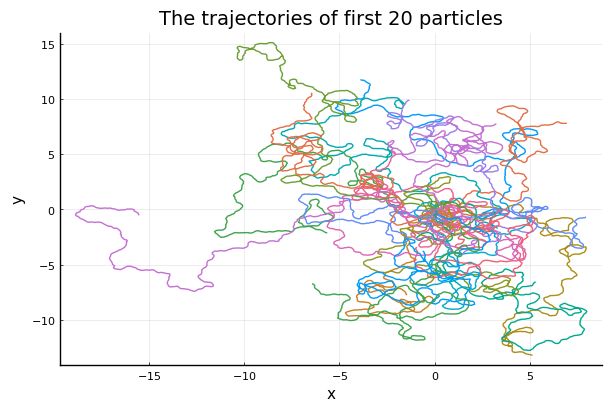

In [41]:
pyplot()
plot(X[1:20,:]',Y[1:20,:]',label=false)
xlabel!("x")
ylabel!("y")
title!("The trajectories of first 20 particles")
savefig("figs/simple.pdf")

### 3.1

In [4]:
function autocorr_direct(ts,ϕ)
    T0=ts[1]
    Δt=ts[2]
    T=ts[end]
    ts=T0:Δt:T
    corrs=[mean(cos.(ϕ[:,k+1:end].-ϕ[:,1:end-k])) for (k,t) in enumerate(ts)]
    return ts,corrs
end

autocorr_direct (generic function with 1 method)

In [26]:
function τᵣfit(t,corr;cut_rate=1/2)
    idx = findfirst(x->x<=0,corr)
    idx = floor(Int,cut_rate*(idx != nothing ? idx - 1 : length(t)))
    t = t[1:idx]
    corr = corr[1:idx]
    data = DataFrame(lnC=log.(corr),T=t)
    model = lm(@formula(lnC~T),data)
    a,b = coef(model)
    return (τᵣ=-1/b,R²=r²(model))
end

τᵣfit (generic function with 1 method)

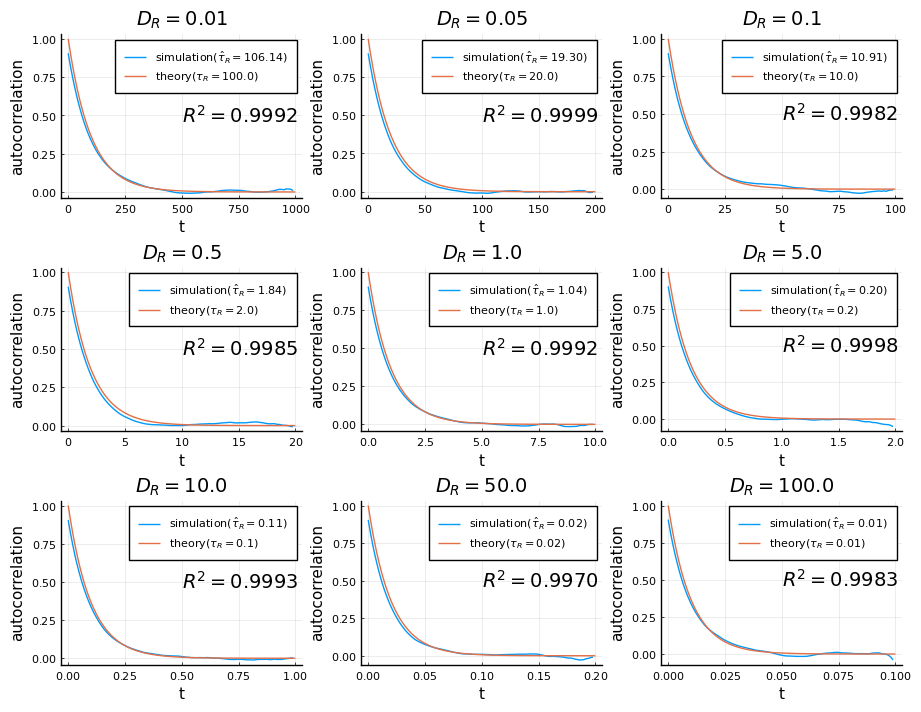

In [43]:
Random.seed!(123456)
N=1000
Dᵣs=[0.01,0.05,0.1,0.5,1,5,10,50,100]
ps=[]

pyplot()
for Dᵣ in Dᵣs
    ts,ϕ=randirect(zeros(N);T=10/Dᵣ,Dᵣ=Dᵣ,Δt=0.1/Dᵣ)
    t,corrs=autocorr_direct(ts,ϕ)
    τᵣ,R²=τᵣfit(t,corrs)
    p=plot(t,corrs,label="simulation(\$\\hat{\\tau}_R=$(@sprintf("%.2f",τᵣ))\$)")
    plot!(p,t->exp(-Dᵣ*t),t,label="theory(\$\\tau_R=$(1/Dᵣ)\$)")
    annotate!(t[end]/2,0.5,text("\$R^2=$(@sprintf("%.4f",R²))\$",:left))
    xlabel!(p,"t")
    ylabel!(p,"autocorrelation")
    title!(p,"\$D_R=$Dᵣ\$")
    push!(ps,p)
end
plot(ps...,layout=(3,3),size=(900,700), margin=1mm)
savefig("figs/Verify_autocorr.pdf")

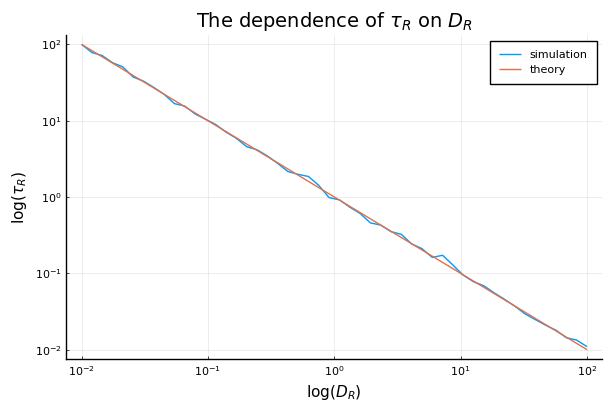

In [35]:
Dᵣs=10 .^ (range(-2,stop=2,length=50))
τᵣs=zero(Dᵣs)
N=1000

for (i,Dᵣ) in enumerate(Dᵣs)
    ts,ϕ=randirect(zeros(N);T=10/Dᵣ,Dᵣ=Dᵣ,Δt=0.1/Dᵣ)
    t,corrs=autocorr_direct(ts,ϕ)
    τᵣs[i],_=τᵣfit(t,corrs)
end

pyplot()
plot(Dᵣs,τᵣs,label="simulation")
plot!(x->1/x,Dᵣs,label="theory")
xlabel!(raw"$\log(D_R)$")
ylabel!(raw"$\log(τ_R)$")
xaxis!(:log)
yaxis!(:log)
title!(raw"The dependence of $τ_R$ on $D_R$")
savefig("figs/dependence of τ and D.pdf")

### 3.2

In [10]:
function MSD(X,Y)
    return mean((X.-X[:,1]).^2 .+ (Y.-Y[:,1]).^2, dims=1)'
end

MSD (generic function with 1 method)

Verify MSD with a set of selected $v$ and $\tau_R=\frac1{D_R}$

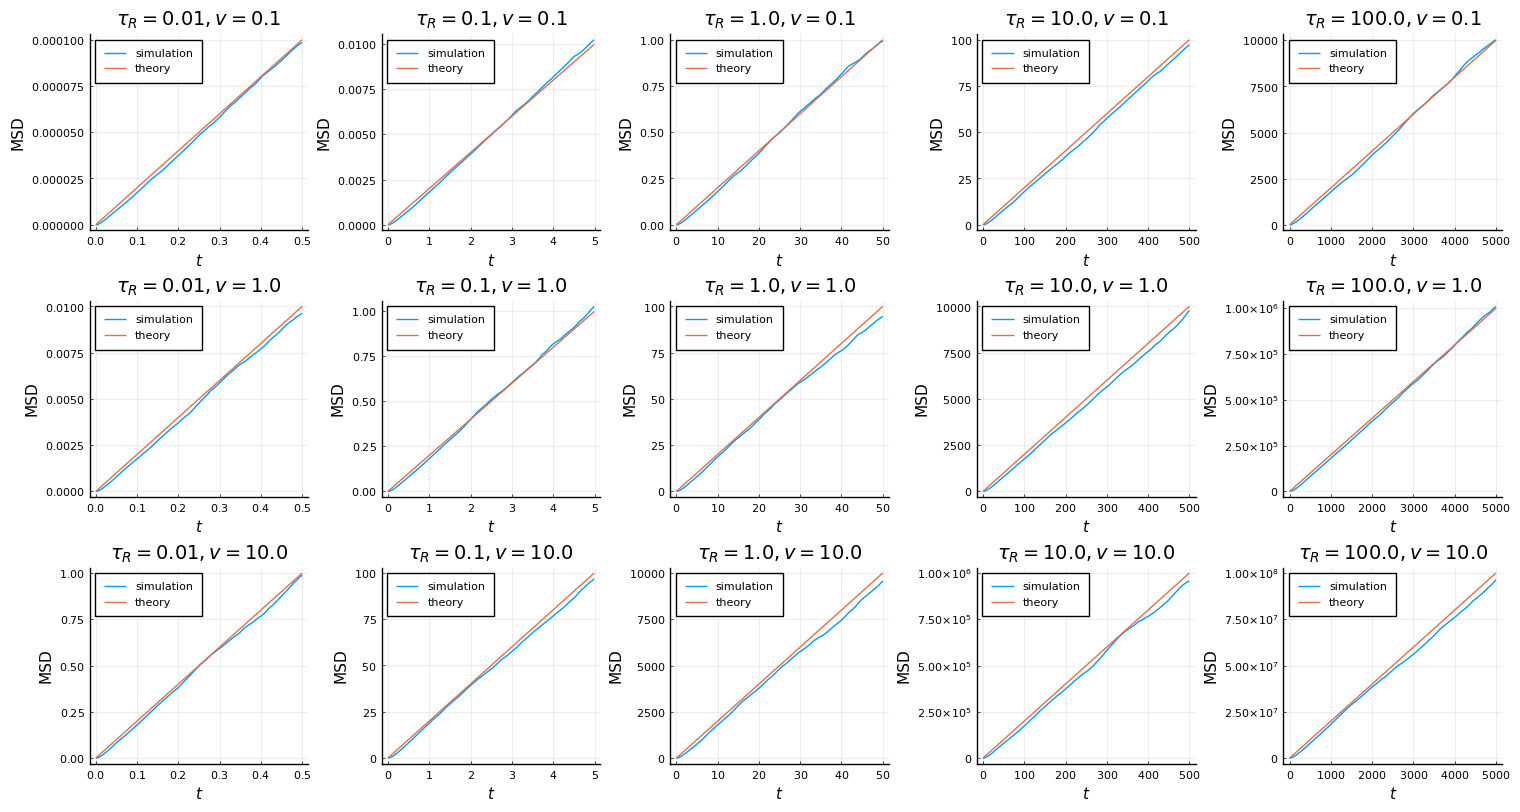

In [12]:
N=1000
vs=[0.1,1,10]
τᵣs=[0.01,0.1,1,10,100]
ps=[]

Random.seed!(12345)

pyplot()
for v in vs
    for τᵣ in τᵣs
        ts,X,Y,ϕ = aBm(zeros(N),zeros(N),rand(Uniform(0,2π),N);T=50τᵣ,Dᵣ=1/τᵣ,v=v,Δt=0.1τᵣ);
        p=plot(ts,MSD(X,Y),label="simulation",legend=:topleft)
        plot!(p,t->2*v^2*τᵣ*t,ts,label="theory")
        title!(p,"\$τ_R=$τᵣ,v=$v\$")
        xlabel!(p,"\$t\$")
        ylabel!(p,"MSD")
        push!(ps,p)
    end
end
plot(ps...,layout=length.((vs,τᵣs)),size=(1500,800), margin=1mm)
savefig("figs/Verify_MSD.pdf")